# Perfect ingredients for a global hit
## Spotify 2020 top tracks analysis


What sets a regular song apart from a track that everyone knows and loves? What makes certain songs unforgettable, while others, despite their quality, fade into obscurity? 

In this analysis, we delve into these intriguing questions, exploring the elements that define a hit song. Using Spotify's 2020 Top Tracks dataset, I will uncover the patterns and characteristics that propel a song to global popularity.

The analysis is structured into four parts:

1. Data Cleaning: Preparing the dataset for a smooth analysis.
2. Exploratory Analysis: Examining key features of the songs and genres.
3. Correlation Analysis: Finding positive, negative and low to none correlating features.
4. Conclusion of an analysis: Summarizing findings and answering the ultimate question—what makes a hit song?

Throughout this journey, I will compare multiple musical features, rank tracks and albums by relevance, and explore trends that differentiate hits from misses. Join me as I uncover the secrets behind the music that dominates the charts and resonates with listeners worldwide!

Let's start with importing libraries, defining spotify data variable and connecting it to the spotify top tracks csv file :

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("spotifytoptracks.csv")

I will also import my own created functions for a smoother analysis :

In [4]:
from MusicAnalysisFunctionsForSpotify import compare_feature_across_genres, analyze_correlations

## Data cleaning
Data cleaning is an essential step in any data analysis process. It ensures that the dataset is accurate, consistent, and ready for meaningful insights. I plan to verify that the data has been imported correctly, check for missing values, identify and remove duplicates, eliminate unnecessary information, and address any outliers. These steps will ensure the dataset is well-prepared and clean for analysis.

Checking if data is imported correctly : 

In [5]:
df.head()

,Unnamed: 0,artist,album,track_name,track_id,energy,danceability,key,loudness,acousticness,speechiness,instrumentalness,liveness,valence,tempo,duration_ms,genre
0,0,The Weeknd,After Hours,Blinding Lights,0VjIjW4GlUZAMYd2vXMi3b,0.730,0.514,1,-5.934,0.00146,0.0598,0.000095,0.0897,0.334,171.005,200040,R&B/Soul
1,1,Tones And I,Dance Monkey,Dance Monkey,1rgnBhdG2JDFTbYkYRZAku,0.593,0.825,6,-6.401,0.68800,0.0988,0.000161,0.1700,0.540,98.078,209755,Alternative/Indie
2,2,Roddy Ricch,Please Excuse Me For Being Antisocial,The Box,0nbXyq5TXYPCO7pr3N8S4I,0.586,0.896,10,-6.687,0.10400,0.0559,0.000000,0.7900,0.642,116.971,196653,Hip-Hop/Rap
3,3,SAINt JHN,Roses (Imanbek Remix),Roses - Imanbek Remix,2Wo6QQD1KMDWeFkkjLqwx5,0.721,0.785,8,-5.457,0.01490,0.0506,0.004320,0.2850,0.894,121.962,176219,Dance/Electronic
4,4,Dua Lipa,Future Nostalgia,Don't Start Now,3PfIrDoz19wz7qK7tYeu62,0.793,0.793,11,-4.521,0.01230,0.0830,0.000000,0.0951,0.679,123.950,183290,Nu-disco


Dropping unnecessary collumn, since it doesn't provide us with much info : 

In [6]:
df = df.drop(columns=["Unnamed: 0"])

Checking for the empty values (there were none) :

In [42]:
df.isnull().sum().sum()

np.int64(0)

In [8]:
# Check for missing values
missing_values = df.isnull().sum()

# Filter for columns with missing values
columns_with_missing = missing_values[missing_values > 0]

if not columns_with_missing.empty:
    print("Missing values found:")
    print(columns_with_missing)
else:
    print("No missing values found.")


No missing values found.


Let's check if there's any duplicate values :

In [9]:
# Check for duplicate rows
num_duplicates = df.duplicated().sum()

if num_duplicates > 0:
    print(f"Number of duplicate rows: {num_duplicates}")
    print("Duplicate rows:")
    print(df[df.duplicated()])
else:
    print("No duplicate rows found.")


No duplicate rows found.


Treating the outliers: This step serves as a formal verification to ensure there are no errors or anomalies in the data. Given that the Spotify Top 50 dataset is already highly curated and "polished," no extreme cases or irregularities were identified.

Typical song durations range from 1 minute (~60,000 ms) to 10 minutes (~600,000 ms). Durations outside this range may be errors. Treatment: cap values within a realistic range.


In [10]:
df["duration_ms"] = df["duration_ms"].clip(lower=60000, upper=600000)

Tempo : unusually low or high values (e.g., below 40 BPM or above 300 BPM) could be errors.
Treatment: use the IQR method or set thresholds for a reasonable tempo range.


In [11]:
df["tempo"] = df["tempo"].clip(lower=40, upper=300)

Acousticness, speechiness, instrumentalness, liveness, valence range must be 0 to 1. Treatment: cap values within the range.

In [12]:
for col in ["acousticness", "speechiness", "instrumentalness", "liveness", "valence"]:
    df[col] = df[col].clip(lower=0, upper=1)

Loudness below -60 dB or above 0 dB) might indicate data errors.
Treatment: use the IQR method or set reasonable thresholds.

In [13]:
Q1 = df["loudness"].quantile(0.25)
Q3 = df["loudness"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = max(Q1 - 1.5 * IQR, -60)
upper_bound = min(Q3 + 1.5 * IQR, 0)

df["loudness"] = df["loudness"].clip(lower=lower_bound, upper=upper_bound)

Key (Integer: 0 to 11) (represents musical key (C=0, C#/Db=1, ..., B=11).
Values outside this range are invalid. Treatment: drop rows or correct invalid entries if present.

In [14]:
df = df[(df["key"] >= 0) & (df["key"] <= 11)]

## Exploratory data analysis
In this section I will compare multiple data features and tendencies in the Spotify top songs list. I will rank and compare artists, albums, genres with each other to find out the most popular among them. Lastly, I will compare what features had positive correlation, negative one and or had none at all.

How many observations and features this dataset has? 

In [15]:
num_observations, num_features = df.shape

print(f"Number of observations (rows): {num_observations}")
print(f"Number of features (columns): {num_features}")

Number of observations (rows): 50
Number of features (columns): 16


Which of the features are categorical and which numeric?

In [16]:
categorical_features = df.select_dtypes(include=["object"]).columns
numeric_features = df.select_dtypes(include=["number"]).columns
print("Categorical Features:", categorical_features.tolist())
print("Numeric Features:", numeric_features.tolist())

Categorical Features: ['artist', 'album', 'track_name', 'track_id', 'genre']
Numeric Features: ['energy', 'danceability', 'key', 'loudness', 'acousticness', 'speechiness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']


Are there any artists that have more than 1 popular track? If yes, which and how many? 

In [17]:
# Count the number of tracks per artist
artist_track_counts = df["artist"].value_counts()

# Filter artists with more than 1 track
artists_with_multiple_tracks = artist_track_counts[artist_track_counts > 1]

# Print the results
if not artists_with_multiple_tracks.empty:
    print("Artists with More Than 1 Popular Track:")
    for artist, track_count in artists_with_multiple_tracks.items():
        print(f"  - {artist}: {track_count} tracks")
else:
    print("No artists have more than 1 popular track.")


Artists with More Than 1 Popular Track:
  - Billie Eilish: 3 tracks
  - Dua Lipa: 3 tracks
  - Travis Scott: 3 tracks
  - Justin Bieber: 2 tracks
  - Harry Styles: 2 tracks
  - Lewis Capaldi: 2 tracks
  - Post Malone: 2 tracks


Who was the most popular artist?

This section creates the dataset and assigns a rank to each track based on its position in the DataFrame :

In [18]:
df["rank"] = df.index + 1

This section groups the data by artist and calculates statistics such as the number of tracks, total rank score, and average rank. The results are sorted to prioritize artists with more tracks and better average ranks :

In [19]:
# Group by artist and calculate stats
artist_stats = df.groupby("artist").agg(
    total_tracks=("rank", "count"),  # Number of tracks per artist
    total_rank_score=("rank", "sum"),  # Sum of ranks for each artist
)

# Add normalized metric: average rank
artist_stats["average_rank"] = (
    artist_stats["total_rank_score"] / artist_stats["total_tracks"]
)

# Sort by total_tracks and average_rank
artist_stats = artist_stats.sort_values(
    by=["total_tracks", "average_rank"], ascending=[False, True]
)

# Display only the top 3 results
top_3_artists = artist_stats.head(3)

print("Top 3 Artist Popularity Stats:")
print(top_3_artists)

Top 3 Artist Popularity Stats:
               total_tracks  total_rank_score  average_rank
artist                                                     
Dua Lipa                  3                86     28.666667
Billie Eilish             3                97     32.333333
Travis Scott              3               128     42.666667


This section visualizes the artist popularity stats using a bar chart for the total number of tracks and a line chart for the average rank. The dual-axis chart helps compare these metrics for each artist :

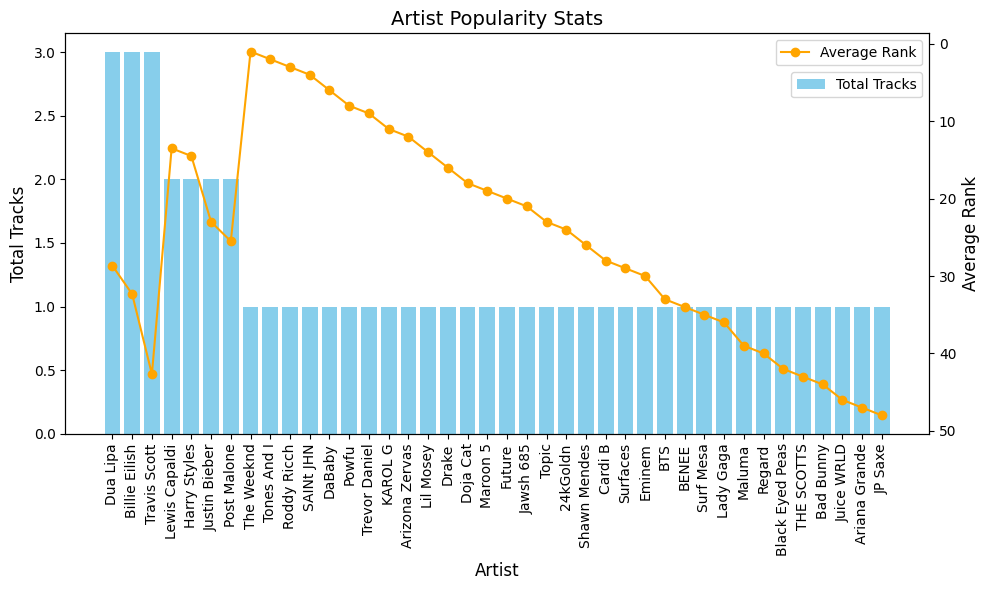

In [20]:
# Plot bar chart for total tracks and average rank
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar chart for total tracks
ax1.bar(artist_stats.index, artist_stats["total_tracks"], color="skyblue", label="Total Tracks")
ax1.set_ylabel("Total Tracks", fontsize=12)
ax1.set_xlabel("Artist", fontsize=12)
ax1.set_title("Artist Popularity Stats", fontsize=14)
ax1.tick_params(axis="x", rotation=45)

# Adjusting font size and rotation
plt.xticks(fontsize=10, rotation=90)

# Line chart for average rank
ax2 = ax1.twinx()
ax2.plot(
    artist_stats.index, 
    artist_stats["average_rank"], 
    color="orange", 
    marker="o", 
    label="Average Rank"
)
ax2.set_ylabel("Average Rank", fontsize=12)
ax2.invert_yaxis()  # Invert average rank (lower rank = better)

# Add legends
ax2.legend(loc="upper right")  # Average Rank legend at the top
ax1.legend(loc="upper right", bbox_to_anchor=(1, 0.92))  # Total Tracks legend just below

plt.tight_layout()
plt.show()


Let's check how many unique artist made it to the top 50 list :

In [21]:
unique_artists_count = df["artist"].nunique()

print(f"Total number of unique artists : {unique_artists_count}")

Total number of unique artists : 40


This section looks deeper in a album analysis and provide answers to the questions :
1. How many albums in total have their songs in the top 50? 
2. Are there any albums that have more than 1 popular track? If yes, which and how many?

In [22]:
total_unique_albums = df["album"].nunique()

print(f"Total number of unique albums in the Top 50: {total_unique_albums}")

album_track_counts = df["album"].value_counts()

albums_with_multiple_tracks = album_track_counts[album_track_counts > 1]

total_albums = len(albums_with_multiple_tracks)

print("Albums with more than 1 popular track:")
print(albums_with_multiple_tracks)

print(f"\nTotal number of albums that have multiple popular tracks: {total_albums}")

Total number of unique albums in the Top 50: 45
Albums with more than 1 popular track:
album
Future Nostalgia        3
Hollywood's Bleeding    2
Fine Line               2
Changes                 2
Name: count, dtype: int64

Total number of albums that have multiple popular tracks: 4


Danceability is a measure used in music analysis to describe how suitable a track is for dancing. It is typically determined by a combination of musical features such as tempo, rhythm stability, beat strength, and overall regularity. Let's see how many tracks had a high danceability score, above 0.7 :

In [23]:
# Filter tracks with a danceability score above 0.7
high_danceability_tracks = df[df["danceability"] > 0.7]

# Count the number of tracks with high danceability
num_high_danceability_tracks = high_danceability_tracks.shape[0]

print(f"Number of tracks with a danceability score above 0.7: {num_high_danceability_tracks}")

Number of tracks with a danceability score above 0.7: 32


This track had a low danceability score, below 0.4 :

In [24]:
low_danceability_tracks = df[df["danceability"] < 0.4]

print("Tracks with a danceability score above 0.7:")
print(low_danceability_tracks[["track_name", "danceability"]])

Tracks with a danceability score above 0.7:
              track_name  danceability
44  lovely (with Khalid)         0.351


Line graph of danceability across all songs :

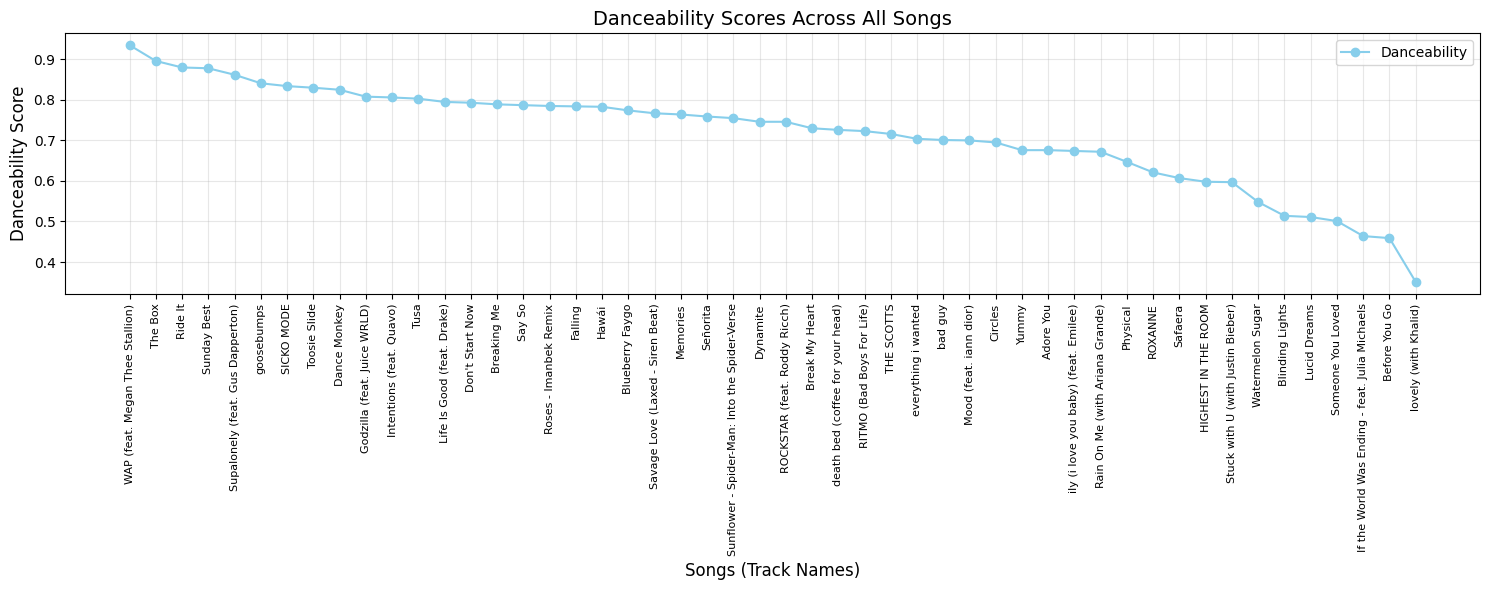

In [25]:
# Sort the dataset by danceability
sorted_df = df.sort_values(by="danceability", ascending=False).reset_index()

# Plot danceability as a line graph
plt.figure(figsize=(15, 6))
plt.plot(sorted_df["track_name"], sorted_df["danceability"], marker="o", linestyle="-", color="skyblue", label="Danceability")

# Customize the chart
plt.title("Danceability Scores Across All Songs", fontsize=14)
plt.xlabel("Songs (Track Names)", fontsize=12)
plt.ylabel("Danceability Score", fontsize=12)
plt.xticks(rotation=90, fontsize=8)  # Rotate track names for better readability
plt.yticks(fontsize=10)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

plt.show()


Loudness in music refers to the perceived intensity or volume of a track. It is a measure of the overall sound level, expressed in decibels (dB), and reflects how loud or soft a piece of music sounds to the human ear. These tracks were quite loud and had their loudness above -5 :

In [26]:
# Filter tracks with a loudness score above -5
high_loudness_tracks = df[df["loudness"] > -5]

# Count the number of tracks with high loudness
num_high_loudness_tracks = high_loudness_tracks.shape[0]

print(f"Number of tracks with a loudness above -5: {num_high_loudness_tracks}")

Number of tracks with a loudness above -5: 19


These tracks had their loudness below -8 :

In [27]:
# Filter tracks with a loudness score below -8
low_loudness_tracks = df[df["loudness"] < -8]

# Count the number of tracks with low loudness
num_low_loudness_tracks = low_loudness_tracks.shape[0]

print(f"Number of tracks with a loudness below -8: {num_low_loudness_tracks}")


Number of tracks with a loudness below -8: 9


Line graph of loudness across all songs :

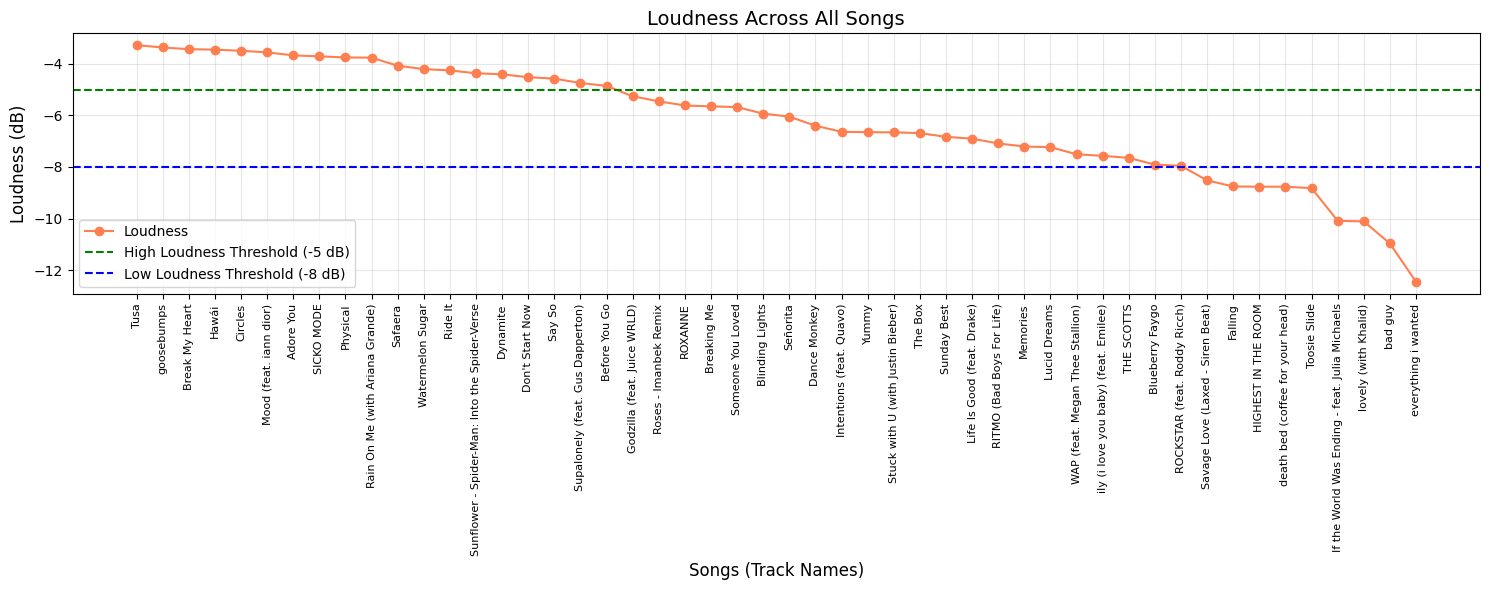

In [28]:
# Sort the dataset by loudness for better visualization
sorted_df = df.sort_values(by="loudness", ascending=False).reset_index()

# Plot loudness as a line graph
plt.figure(figsize=(15, 6))
plt.plot(sorted_df["track_name"], sorted_df["loudness"], marker="o", linestyle="-", color="coral", label="Loudness")

# Customize the chart
plt.title("Loudness Across All Songs", fontsize=14)
plt.xlabel("Songs (Track Names)", fontsize=12)
plt.ylabel("Loudness (dB)", fontsize=12)
plt.axhline(-5, color="green", linestyle="--", label="High Loudness Threshold (-5 dB)")
plt.axhline(-8, color="blue", linestyle="--", label="Low Loudness Threshold (-8 dB)")
plt.xticks(rotation=90, fontsize=8)  # Rotate track names for better readability
plt.yticks(fontsize=10)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

plt.show()


Which tracks are the longest and the shortest?

This section identifies the longest and shortest tracks in the dataset and converts their durations to a more readable minutes and seconds format :

In [29]:
# Find the longest and shortest tracks
longest_track = df[df["duration_ms"] == df["duration_ms"].max()].copy()
shortest_track = df[df["duration_ms"] == df["duration_ms"].min()].copy()

# Convert duration from milliseconds to minutes and seconds
longest_track["duration_min_sec"] = longest_track["duration_ms"].apply(
    lambda x: f"{x // 60000} min {(x % 60000) // 1000:02d} sec"
)
shortest_track["duration_min_sec"] = shortest_track["duration_ms"].apply(
    lambda x: f"{x // 60000} min {(x % 60000) // 1000:02d} sec"
)

print("Longest Track:")
print(longest_track[["track_name", "duration_min_sec"]])

print("\nShortest Track:")
print(shortest_track[["track_name", "duration_min_sec"]])



Longest Track:
    track_name duration_min_sec
49  SICKO MODE     5 min 12 sec

Shortest Track:
                track_name duration_min_sec
23  Mood (feat. iann dior)     2 min 20 sec


This section calculates the average track length by taking the mean of all track durations in the dataset and formats it as minutes and seconds :

In [30]:
# Calculate average track length across all tracks
average_duration_ms = df["duration_ms"].mean()  # Mean duration in milliseconds
average_duration_min_sec = f"{int(average_duration_ms // 60000)} min {int((average_duration_ms % 60000) // 1000):02d} sec"

print(f"\nAverage Track Length (calculated across all tracks): {average_duration_min_sec}")


Average Track Length (calculated across all tracks): 3 min 19 sec


Which genre is the most popular? Which genres have just one song on the top 50? How many genres in total are represented in the top 50?

This section determinates the most popular genre, identifies genres with only one song, calculates the unique genres and groups the data for a pie chart :

In [31]:
# Calculate the most popular genre and its count
most_popular_genre = df["genre"].value_counts().idxmax()
most_popular_genre_count = df["genre"].value_counts().max()

# Identify genres with only one song
genres_with_one_song = (
    df["genre"].value_counts()[df["genre"].value_counts() == 1].index.tolist()
)

# Calculate the total number of unique genres
total_genres = df["genre"].nunique()

# Group genres for the pie chart
genre_counts = df["genre"].value_counts()

# Separate "Other Genres" (genres with only 1 song)
main_genres = genre_counts[genre_counts > 1]
other_genres_count = genre_counts[genre_counts == 1].sum()

# Add "Other Genres" to the main genres
main_genres["Other Genres"] = other_genres_count

Genres popularity visualised in a pie chart ('Other Genres' stands for all the genres that had only 1 song in the top 50 list) : 

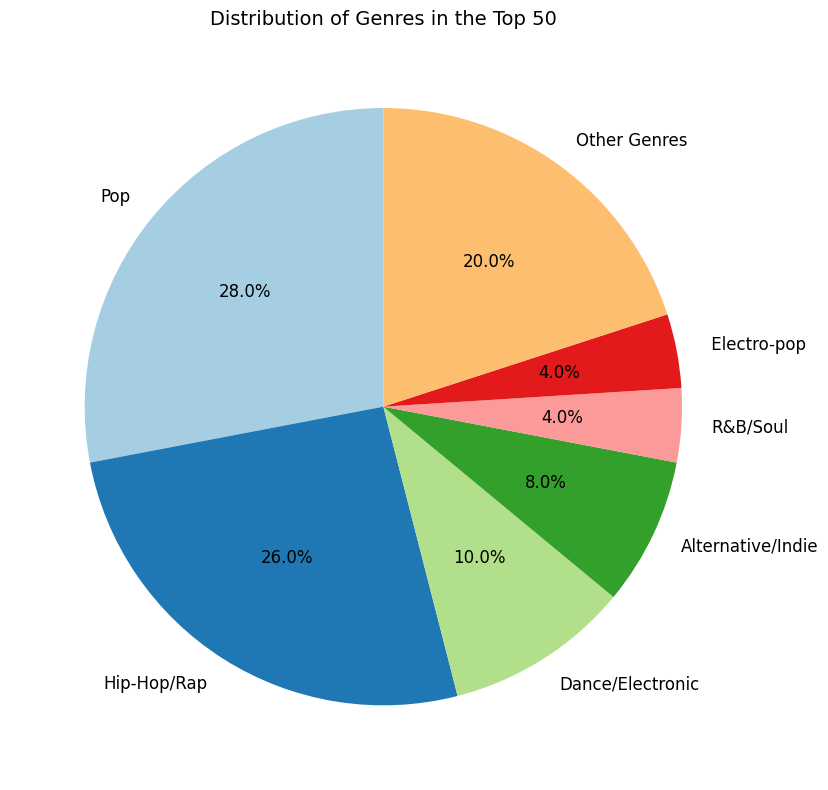

The most popular genre is 'Pop' with 14 songs, followed by 'Hip-Hop/Rap' and 'Other Genres' close by.

Other genres with just one song in the top 50:
['Nu-disco', 'R&B/Hip-Hop alternative', 'Pop/Soft Rock', 'Pop rap', 'Hip-Hop/Trap', 'Dance-pop/Disco', 'Disco-pop', 'Dreampop/Hip-Hop/R&B', 'Alternative/reggaeton/experimental', 'Chamber pop']

Total number of genres represented in the top 50: 16


In [32]:
# Create the pie chart
plt.figure(figsize=(10, 8))
main_genres.plot(
    kind="pie", 
    autopct="%1.1f%%", 
    startangle=90, 
    textprops={"fontsize": 12}, 
    colors=plt.cm.Paired.colors,
    label=""
)
plt.title("Distribution of Genres in the Top 50", fontsize=14)
plt.ylabel("")  # Remove default y-axis label

plt.tight_layout()
plt.show()

print(f"The most popular genre is '{most_popular_genre}' with {most_popular_genre_count} songs, followed by 'Hip-Hop/Rap' and 'Other Genres' close by.")
print(f"\nOther genres with just one song in the top 50:")
print(genres_with_one_song)
print(f"\nTotal number of genres represented in the top 50: {total_genres}")

How does the danceability, loudness and acousticness score compare between Pop, Hip-Hop/Rap, Dance/Electronic, and Alternative/Indie genres?

Analysis on how does the danceability score compare between Pop, Hip-Hop/Rap, Dance/Electronic, and Alternative/Indie genres, followed by a bar graph and conclusion :

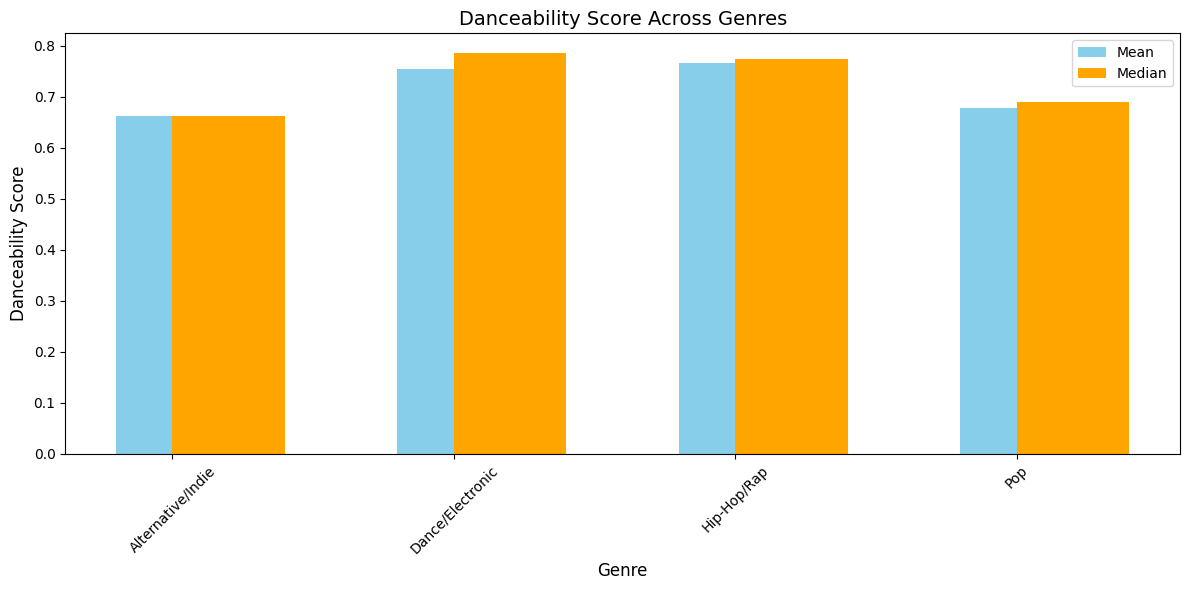


Danceability Score Summary:
  - The genre with the highest mean danceability is 'Hip-Hop/Rap' with 0.77.
  - The genre with the highest median danceability is 'Dance/Electronic' with 0.79.
  - Comparison for all genres:
    * Alternative/Indie: mean = 0.66, median = 0.66, range = 0.46 to 0.86.
    * Dance/Electronic: mean = 0.76, median = 0.79, range = 0.65 to 0.88.
    * Hip-Hop/Rap: mean = 0.77, median = 0.77, range = 0.60 to 0.90.
    * Pop: mean = 0.68, median = 0.69, range = 0.46 to 0.81.


In [33]:
compare_feature_across_genres(
    df, 
    genres=["Pop", "Hip-Hop/Rap", "Dance/Electronic", "Alternative/Indie"], 
    feature="danceability", 
    title="Danceability Score"
)

Analysis on how does the loudness score compare between Pop, Hip-Hop/Rap, Dance/Electronic, and Alternative/Indie genres, followed by a bar graph and conclusion :

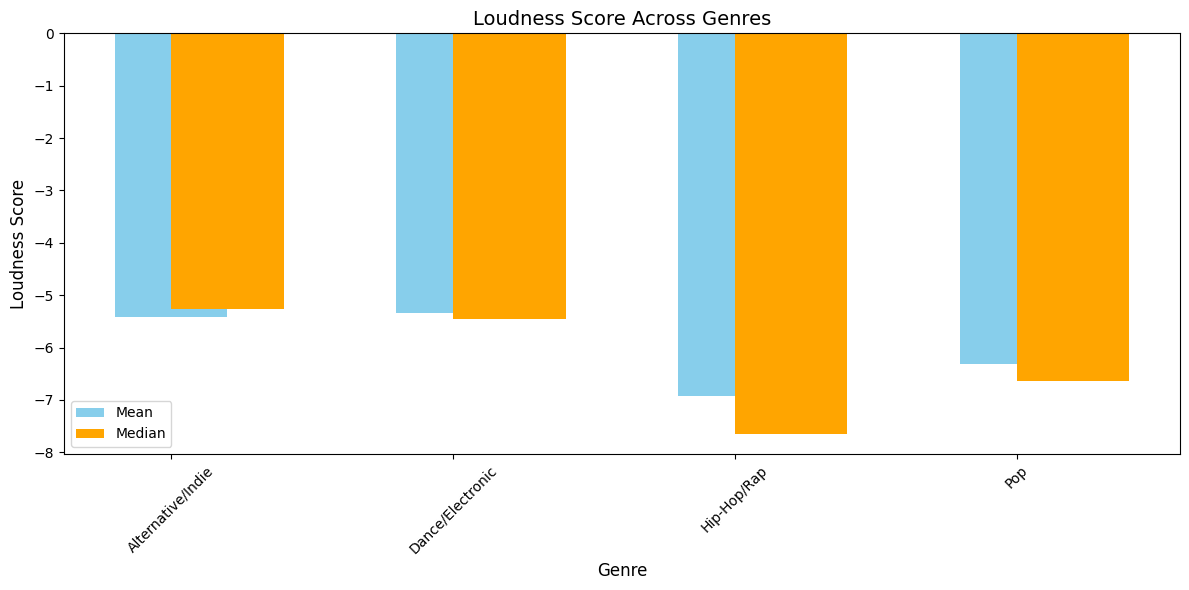


Loudness Score Summary:
  - The genre with the highest mean loudness is 'Dance/Electronic' with -5.34.
  - The genre with the highest median loudness is 'Alternative/Indie' with -5.27.
  - Comparison for all genres:
    * Alternative/Indie: mean = -5.42, median = -5.27, range = -6.40 to -4.75.
    * Dance/Electronic: mean = -5.34, median = -5.46, range = -7.57 to -3.76.
    * Hip-Hop/Rap: mean = -6.92, median = -7.65, range = -8.82 to -3.37.
    * Pop: mean = -6.32, median = -6.64, range = -12.45 to -3.28.


In [34]:
compare_feature_across_genres(
    df, 
    genres=["Pop", "Hip-Hop/Rap", "Dance/Electronic", "Alternative/Indie"], 
    feature="loudness", 
    title="Loudness Score"
)


Analysis on how does the acousticness score compare between Pop, Hip-Hop/Rap, Dance/Electronic, and Alternative/Indie genres, followed by a bar graph and conclusion :

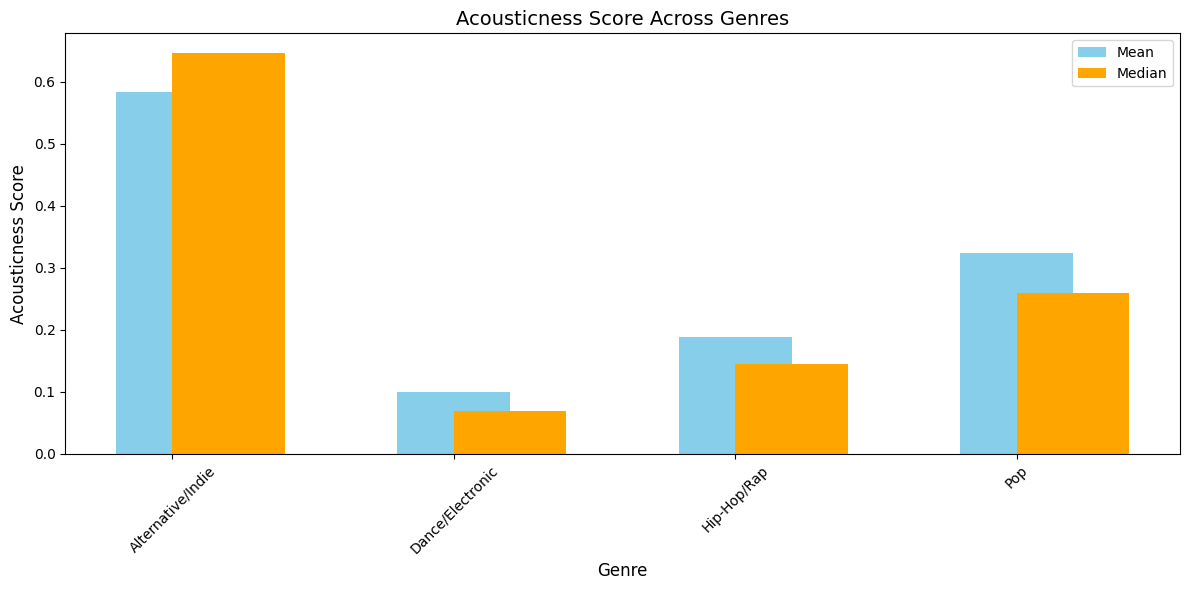


Acousticness Score Summary:
  - The genre with the highest mean acousticness is 'Alternative/Indie' with 0.58.
  - The genre with the highest median acousticness is 'Alternative/Indie' with 0.65.
  - Comparison for all genres:
    * Alternative/Indie: mean = 0.58, median = 0.65, range = 0.29 to 0.75.
    * Dance/Electronic: mean = 0.10, median = 0.07, range = 0.01 to 0.22.
    * Hip-Hop/Rap: mean = 0.19, median = 0.14, range = 0.01 to 0.73.
    * Pop: mean = 0.32, median = 0.26, range = 0.02 to 0.90.


In [35]:
compare_feature_across_genres(
    df, 
    genres=["Pop", "Hip-Hop/Rap", "Dance/Electronic", "Alternative/Indie"], 
    feature="acousticness", 
    title="Acousticness Score"
)


# Correlation analysis
Which features are strongly positively, negatively or have little to none correlation? Exploring the results and showing them in a form of a heatmap.

Select numerical columns and calculate the correlation matrix :

In [36]:
numerical_df = df.select_dtypes(include=["number"])
correlation_matrix = numerical_df.corr()

Let's analyze strong positive correlations :

In [37]:
analyze_correlations(
    correlation_matrix, 
    threshold=0.7, 
    description="Strong Positive Correlations (r > 0.7)", 
    condition=">"
)


Conclusion: Strong Positive Correlations (r > 0.7)
  energy-loudness (r=0.79)


Again, let's analyze strong negative correlations :

In [38]:
analyze_correlations(
    correlation_matrix, 
    threshold=-0.7, 
    description="Strong Negative Correlations (r < -0.7)", 
    condition="<"
)



Conclusion: Strong Negative Correlations (r < -0.7)
  No correlations found.


And finally let's analyze features with no correlations :

In [39]:
analyze_correlations(
    correlation_matrix, 
    threshold=(-0.1, 0.1), 
    description="Features with No Correlation (-0.1 < r < 0.1)", 
    condition="range"
)



Conclusion: Features with No Correlation (-0.1 < r < 0.1)
  Too many correlations to display (35 found). Examples: energy-key, energy-speechiness, energy-liveness, energy-tempo, energy-duration_ms, energy-rank, danceability-instrumentalness, danceability-liveness, danceability-duration_ms, key-loudness...


Heatmap of correlations :

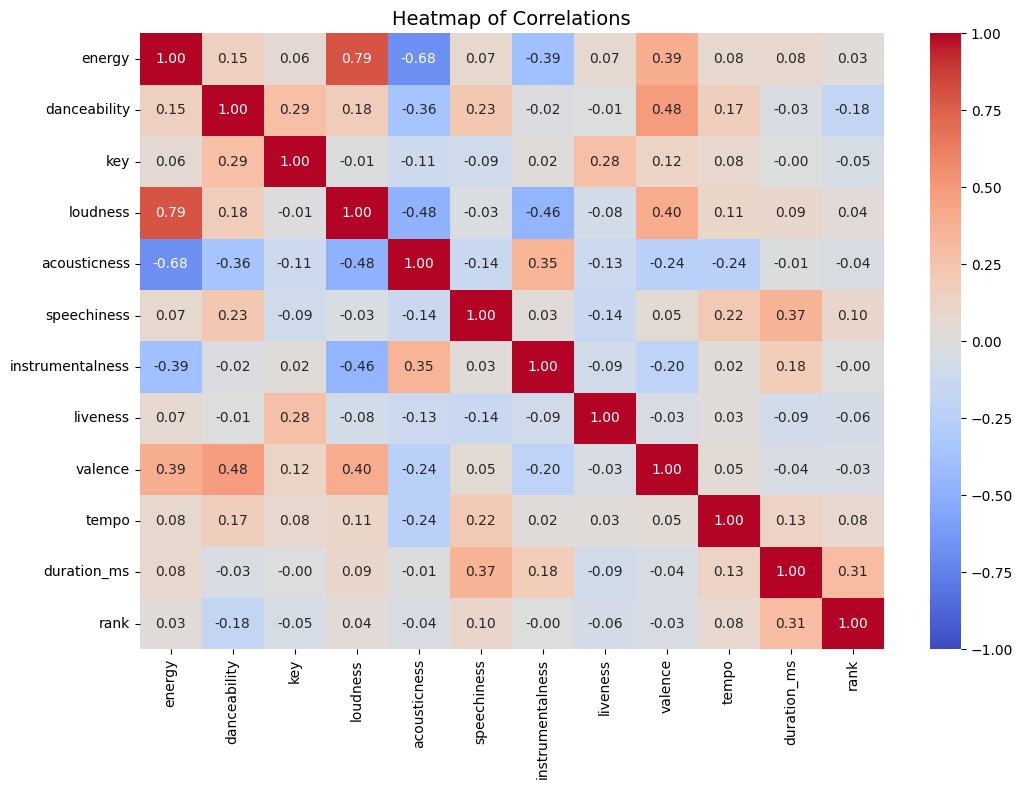

In [40]:
# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    correlation_matrix, 
    annot=True,  # Set to True to display values on the heatmap
    cmap="coolwarm", 
    cbar=True,
    fmt=".2f",
    vmin=-1, vmax=1,
)
plt.title("Heatmap of Correlations", fontsize=14)
plt.show()

From the heatmap information, we can see that energy and loudness had highest correlation, while the acousticness and energy had the lowest one.

# Conclusion of an analysis

From the 50 top-hit observations, we can identify several factors that contribute to a song becoming a blockbuster hit. The standout artists of 2020 were undoubtedly Dua Lipa, Billie Eilish, and Travis Scott, each dominating the Spotify charts with three hit tracks. Interestingly, track loudness did not play a significant role in determining a song's success; however, a slight trend toward higher loudness levels was observed among the hits.

A notable feature of the 2020 chart was the diversity of artists—40 unique performers were represented, indicating that listeners had a broad range of preferences rather than favoring just a few dominant names. As expected, pop music reigned as the most popular genre. Other genres, such as Nu-disco, R&B/Hip-Hop Alternative, Pop/Soft Rock, Pop Rap, Hip-Hop/Trap, Dance-pop/Disco, and others, had only one track each on the list, reflecting limited popularity. In total, the chart showcased a rich genre diversity with 16 distinct genres represented.

Song durations were fairly traditional, with the shortest track at 2:20 minutes and the longest at 5:12 minutes. Energy and loudness had the highest correlation among the analyzed features, while there were no strong negative correlations (the strongest negative pair was acousticness and energy), and many features showed little to no correlation with each other. High danceability was a clear preference in the top charts, with songs featuring higher danceability scores being far more prevalent than those with lower scores.

So what are the perfect ingredients for global hit? It’s a mix of catchy rhythms, genre appeal, and emotional resonance. Features like energy, danceability, and loudness create the dynamic soundscapes that listeners gravitate toward. Pop music, with its universal appeal and relatable lyrics, consistently strikes a chord with audiences, as well as Hip-Pop and Rap music genre. Meanwhile, diversity in genres and artists demonstrates that a hit song doesn’t have to conform to one specific formula—creativity and distinctiveness also play a key role. Artists who can balance these factors while staying relevant to cultural and listener trends are more likely to craft songs that capture widespread attention.

In conclusion, the 2020 Top 50 chart reflects a year of musical variety and innovation, showing that blockbuster hits are born from a combination of technical features, genre diversity, and the ability to connect with audiences on a deeper level. As the music landscape evolves, the blueprint for a hit song will continue to shift, driven by trends, technology, and creativity. 